<a href="https://colab.research.google.com/github/HananEltale/Cybersecurity/blob/main/_spam_mail_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proje Amacı

---
Bu proje, spam (istenmeyen) ve ham (normal) e-postaları makine öğrenmesi yöntemleriyle otomatik olarak sınıflandırarak kullanıcıların gelen kutularını korumayı hedeflemektedir. Adli bilişim açısından kritik bir öneme sahiptir çünkü spam e-postalar, phishing (kimlik avı), dolandırıcılık ve malware yayma gibi siber suçlarda sıkça kullanılmaktadır.


Veri Seti

---




Projede kullanılan veri seti, Kaggle üzerinden alınmıştır:  https://www.kaggle.com/datasets/venky73/spam-mails-dataset/data















Projeyi Hazırlayan


---



Hanan Eltaleb-215509601













In [ ]:
# Google drive mount ederek veri setini alma
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gerekli Kütüphanelerin İçe Aktarılması


In [ ]:
# Veri işleme (pandas, numpy) ve modelleme (sklearn) için gerekli kütüphaneleri import etme.
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split #Veriyi eğitim ve test setlerine ayırmak için.
from sklearn.feature_extraction.text import TfidfVectorizer #Metinleri sayısal özelliklere dönüştürmek için.
from sklearn.linear_model import LogisticRegression #Sınıflandırma modeli için.
from sklearn.metrics import accuracy_score  #Model performansını ölçmek için.

Veri Ön İşleme


In [ ]:
# Verileri CSV dosyasından bir pandas DataFrame'ine yükleme.
raw_mail_data = pd.read_csv('/content/drive/My Drive/spam_ham_dataset.csv', encoding='ISO-8859-1')


In [ ]:
#Verilerin ham halini yazdırma.
print(raw_mail_data)

      Unnamed: 0 label                                               text  \
0            605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1           2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2           3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3           4685  spam  Subject: photoshop , windows , office . cheap ...   
4           2030   ham  Subject: re : indian springs\r\nthis deal is t...   
...          ...   ...                                                ...   
5166        1518   ham  Subject: put the 10 on the ft\r\nthe transport...   
5167         404   ham  Subject: 3 / 4 / 2000 and following noms\r\nhp...   
5168        2933   ham  Subject: calpine daily gas nomination\r\n>\r\n...   
5169        1409   ham  Subject: industrial worksheets for august 2000...   
5170        4807  spam  Subject: important online banking alert\r\ndea...   

      label_num  
0             0  
1             0  
2             0  
3  

In [ ]:
#Boş (null) değerleri boş stringler ile değiştirme.
mail_data = raw_mail_data.where((pd.notnull(raw_mail_data)),'')

In [ ]:
#DataFrame'nin ilk 5 satırını yazdırma.
mail_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Veri setindeki kullanılmayan sütunları kaldırmaa.
mail_data = mail_data.drop(columns=['Unnamed: 0', 'label_num'])

In [ ]:
mail_data.head()

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
# Veri setinin satır ve sütun sayısını gösterme
mail_data.shape

(5171, 2)

In [ ]:
#Tekrar eden satırların sayısını bulma.
mail_data.duplicated().sum()

np.int64(178)

In [ ]:
# Veri setindeki tekrarlayan satırları silme.
mail_data= mail_data.drop_duplicates(keep='first')

#Tekrar eden satırların sayısını kontrol etme.
mail_data.duplicated().sum()

np.int64(0)

In [ ]:
#'label' sütunundaki spam ve ham etiketlerini sayısal olarak ifade edebilmek için:
# spam = 0, ham = 1 olarak değiştirme.
mail_data.loc[mail_data['label'] == 'spam', 'label'] = 0
mail_data.loc[mail_data['label'] == 'ham', 'label'] = 1

<ipython-input-163-2446933302>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mail_data.loc[mail_data['label'] == 'spam', 'label'] = 0
<ipython-input-163-2446933302>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mail_data.loc[mail_data['label'] == 'ham', 'label'] = 1


spam  -  0

ham  -  1

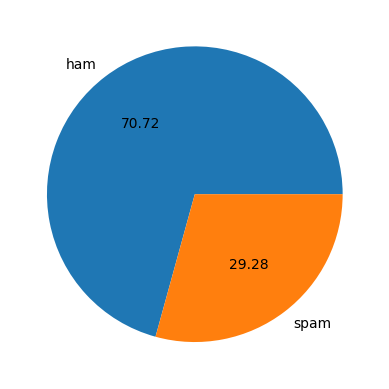

In [ ]:
#Veri setindeki e-postaların ne kadarının "ham" ve ne kadarının "spam" olduğunu anlama.
import matplotlib.pyplot as plt
plt.pie(mail_data['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [ ]:
#Veri setini özellikler (X) ve etiketler (Y) olarak ayırmak.
X = mail_data['text'] # E-posta metinleri (özellikler)
Y = mail_data['label'] # Etiketler (spam/ham)

In [ ]:
print(X)

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
5165    Subject: fw : crosstex energy , driscoll ranch...
5166    Subject: put the 10 on the ft\r\nthe transport...
5167    Subject: 3 / 4 / 2000 and following noms\r\nhp...
5169    Subject: industrial worksheets for august 2000...
5170    Subject: important online banking alert\r\ndea...
Name: text, Length: 4993, dtype: object


In [ ]:
print(Y)

0       1
1       1
2       1
3       0
4       1
       ..
5165    1
5166    1
5167    1
5169    1
5170    0
Name: label, Length: 4993, dtype: object


Veriyi eğitim verisi ve test verisi olarak ayırma


In [ ]:
#Veri kümesini %80 eğitim, %20 test olacak şekilde ve rastgelelik sabiti 3 olacak biçimde X (özellikler) ve Y (etiketler) üzerinden eğitim ve test setlerine böldüm. Veriyi eğitim ve test olarak ayırmak, modelin sadece ezber yapmadığından emin olmak için .
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [ ]:
# Eğitim ve test setlerinin boyutlarını yazdırma
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(4993,)
(3994,)
(999,)


Özellik Çıkarma

In [ ]:
#Metin verisini sayısal verilere dönüştürmek için TF-IDF vektörleştirici oluşturma:
#İngilizce'deki gereksiz kelimeleri çıkarmak.
#Metindeki tüm harfleri küçük harfe çevirmek
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase=True)
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

# Y_train ve Y_test değerlerini integer'e çevirmek.

Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

In [ ]:
print(X_train)

2493       Subject: learn to make a fortune on ebay !\r\n
2141    Subject: re : rate for tenaska deal\r\ndaren ,...
2143    Subject: italian rolex in throw away prices . ...
2246    Subject: did you see my picture ?\r\nhi it ' s...
1275    Subject: 12 th nom going back to 70 into midco...
                              ...                        
796     Subject: impress her with a hard erection . . ...
978     Subject: re : central power & light\r\nno reco...
1696    Subject: do you like computers\r\nincredible o...
3415    Subject: new product ! cialis soft tabs .\r\nh...
1718    Subject: midtex\r\ndaren -\r\ni need a service...
Name: text, Length: 3994, dtype: object


In [ ]:
print(X_train_features)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 267661 stored elements and shape (3994, 43983)>
  Coords	Values
  (0, 38068)	0.08632840173723072
  (0, 25103)	0.4662578469095977
  (0, 26280)	0.2982705338173961
  (0, 18587)	0.557645693321033
  (0, 15779)	0.6125495870748028
  (1, 38068)	0.03747564753664442
  (1, 33380)	0.2783514308434747
  (1, 39005)	0.2400521335021388
  (1, 13675)	0.10051353969511687
  (1, 13499)	0.13044974405231805
  (1, 39177)	0.05764146937583861
  (1, 10433)	0.06393859621026157
  (1, 24504)	0.06309539261124628
  (1, 12030)	0.0886370802732481
  (1, 12784)	0.19753425051965484
  (1, 37619)	0.09010841211659963
  (1, 35345)	0.39026367474220075
  (1, 17638)	0.07756296633236258
  (1, 234)	0.09677245580250261
  (1, 787)	0.0465254462177623
  (1, 1001)	0.055136605920593836
  (1, 326)	0.037014421659383547
  (1, 1881)	0.05855730663416534
  (1, 8813)	0.161384766640587
  (1, 21504)	0.06951833846460254
  :	:
  (3993, 41772)	0.10479615859283661
  (3993, 26343)	0.1294435

Modelin Eğitilmesi

Lojistik Regresyon


In [ ]:
#lojistik regresyon sınıflandırma modelini oluşturma.

model = LogisticRegression()

In [ ]:
#Oluşturulan lojistik regresyon modelini eğitim verisiyle eğitme.
model.fit(X_train_features, Y_train)

LogisticRegression()

Modelin Değerlendirilmesi

In [ ]:
# Eğitim verileri üzerinde tahmin yapma
prediction_on_training_data = model.predict(X_train_features)
# Eğitim verisi üzerindeki doğruluk oranını hesaplama
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)

In [ ]:
print('Accuracy on training data : ', accuracy_on_training_data)

Accuracy on training data :  0.9957436154231347


In [ ]:
# Test verisi üzerinde tahmin yapma
prediction_on_test_data = model.predict(X_test_features)
# Test verisi üzerindeki doğruluğu hesaplama
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)

In [ ]:
print('Accuracy on test data : ', accuracy_on_test_data)

Accuracy on test data :  0.987987987987988


Accuracy (Doğruluk): 0.9880


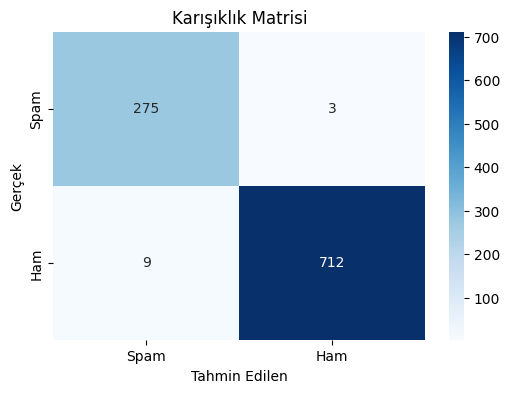

              precision    recall  f1-score   support

        Spam       0.97      0.99      0.98       278
         Ham       1.00      0.99      0.99       721

    accuracy                           0.99       999
   macro avg       0.98      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999



In [ ]:
#Karışıklık matrisini hesaplama
# Gerekli kütüphaneleri içe aktarma
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Test verisi üzerinde tahmin yapma
y_pred = model.predict(X_test_features)  # Modelin tahminleri

# Karışıklık matrisini oluşturma
cm = confusion_matrix(Y_test, y_pred)  # Gerçek vs tahmin edilen

# Accuracy (doğruluk) hesaplama
accuracy = accuracy_score(Y_test, y_pred)  # Doğru tahmin oranı
print(f"Accuracy (Doğruluk): {accuracy:.4f}")  # Virgülden sonra 4 basamak

# Etiketleri tanımlama
labels = ['Spam', 'Ham']  # 0 = Spam, 1 = Ham

# Karışıklık matrisini çizme
plt.figure(figsize=(6, 4))  # Grafik boyutu
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # annot=True → sayıları göster
            xticklabels=labels, yticklabels=labels)  # Etiketler

plt.xlabel('Tahmin Edilen')      # X ekseni etiketi
plt.ylabel('Gerçek')             # Y ekseni etiketi
plt.title('Karışıklık Matrisi')  # Başlık
plt.show()

# Precision, recall, f1 gibi metrikleri yazdırma
print(classification_report(Y_test, y_pred, target_names=labels))


 Tahmin Sistemi Oluşturma

In [ ]:
#Kullanıcıdan bir e-posta metni alma.
message=input("Enter the message: ")

#Girilen mesajı TF-IDF ile vektöre dönüştürme
input_data_features = feature_extraction.transform([message])

#Eğitilmiş modelle spam/ham tahmini yapma.
prediction = model.predict(input_data_features)
print(prediction)

#Tahmin sonucuna göre kullanıcıya e-postanın spam mi yoksa normal (ham) mi olduğunu bildirme.

if (prediction[0]==1):
  print('Ham mail')

else:
  print('Spam mail')

Enter the message: Congratulations! You won a $1M lottery. Claim your prize: http://free-lottery.win
[0]
Spam mail


In [ ]:
# Modeli test etmek için Kullandığım örnek e-postalar:
#Spam:
# "Congratulations! You won a $1M lottery. Claim your prize: http://free-lottery.win"

#Ham:
#"Hi Sarah,Just a friendly reminder about our hair appointment on Friday, June 20 at 3:00 PM. Please let me know if you'd like to reschedule."


